# Manitoba Agriculture Capstone Project

## Objective
This notebook is the starting point for building a prototype decision support dashboard for farmers in Manitoba. The end goal is to provide guidance on crop plantation timing, flood alerts, and severe weather conditions using open datasets and APIs.

## Approach
We will proceed step by step:
1. Explore and ingest available datasets (weather, crop yields, satellite imagery, flood warnings).
2. Perform basic preprocessing and cleaning to make the data usable.
3. Run simple exploratory analyses and visualizations to understand patterns.
4. Prepare outputs that can later be integrated into a Streamlit dashboard.

## Scope
- Run locally on a laptop, minimizing computation and storage requirements.
- Use open and free data sources only.
- Focus on feasibility and demonstration rather than production deployment.

---


In [2]:
# Basic environment check and library imports

import sys
print("Python version:", sys.version)

# Core data handling
import pandas as pd
import numpy as np

# For making API requests
import requests

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: geospatial and raster handling (we'll use later for Sentinel imagery)
# import geopandas as gpd
# import rasterio

print("Libraries imported successfully.")


Python version: 3.11.13 (main, Jun  5 2025, 08:14:07) [Clang 14.0.6 ]
Libraries imported successfully.


In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/vlyubchich/Manitoba/refs/heads/master/data/Yields.csv"
yields = pd.read_csv(url)

# Inspect the first few rows
yields.head()


,Year,Municipality,Crop,Variety,Farms,Acres,Yield/Acre,t,i
0,1996,ALEXANDER,ARGENTINE CANOLA,INNOVATOR (HCN 92) (LT),3,575.0,0.579,1,1
1,1996,ALEXANDER,ARGENTINE CANOLA,QUANTUM (91-21864 NA),6,1125.0,0.780,1,1
2,1996,ALEXANDER,ARGENTINE CANOLA,45A71 (NS1471)(ST),4,1012.0,0.756,1,1
3,1996,ALEXANDER,BARLEY,ROBUST,9,1247.0,1.607,1,1
4,1996,ALEXANDER,CANARYSEED,KEET,3,535.0,0.184,1,1


## Exploring the Crop Yield Dataset

We have loaded the Manitoba crop yield dataset (`Yields.csv`) from GitHub.  
This dataset contains historical records of crop yields across municipalities, crop types, and varieties.  
Key columns include:
- **Year**: Year of record
- **Municipality**: Location of the farm
- **Crop**: Crop type (e.g., Canola, Barley, Wheat)
- **Variety**: Specific crop variety
- **Farms**: Number of farms reporting
- **Acres**: Total acres planted
- **Yield/Acre**: Yield per acre (metric tons or bushels depending on crop)

Next, we will explore the dataset to understand its structure, size, and basic statistics.


In [4]:
# Basic exploration of the crop yield dataset

# Shape of the dataset (rows, columns)
print("Dataset shape:", yields.shape)

# Column names
print("Columns:", yields.columns.tolist())

# Summary statistics for numeric columns
print("\nSummary statistics:")
print(yields.describe())

# Unique crops and municipalities
print("\nUnique crops:", yields['Crop'].nunique())
print("Unique municipalities:", yields['Municipality'].nunique())

# First 10 unique crop names
print("\nSample crop types:", yields['Crop'].unique()[:10])


Dataset shape: (44448, 9)
Columns: ['Year', 'Municipality', 'Crop', 'Variety', 'Farms', 'Acres', 'Yield/Acre', 't', 'i']

Summary statistics:
               Year         Farms         Acres    Yield/Acre             t  \
count  44448.000000  44448.000000  44448.000000  44448.000000  44448.000000   
mean    2003.584998     12.866248   2538.648214      1.101516      8.585066   
std        4.526861     14.250165   3886.195863      1.050142      4.526905   
min     1996.000000      3.000000    500.000000      0.001000      1.000000   
25%     2000.000000      5.000000    807.000000      0.665000      5.000000   
50%     2004.000000      8.000000   1345.000000      0.922000      9.000000   
75%     2008.000000     15.000000   2619.000000      1.297000     13.000000   
max     2011.000000    261.000000  84650.000000     17.708000     16.000000   

                  i  
count  44448.000000  
mean      50.542499  
std       27.327499  
min        1.000000  
25%       29.000000  
50%       52.0

## Visualizing Yield Trends for Canola

We will filter the dataset for Canola varieties and plot the average yield per acre over time.
This helps us see how yields have changed across years and provides a baseline for forecasting.


Canola yield trend stats:
              Year  Yield/Acre
count    16.000000   16.000000
mean   2003.500000    0.699519
std       4.760952    0.100403
min    1996.000000    0.529702
25%    1999.750000    0.630192
50%    2003.500000    0.695225
75%    2007.250000    0.726223
max    2011.000000    0.926255


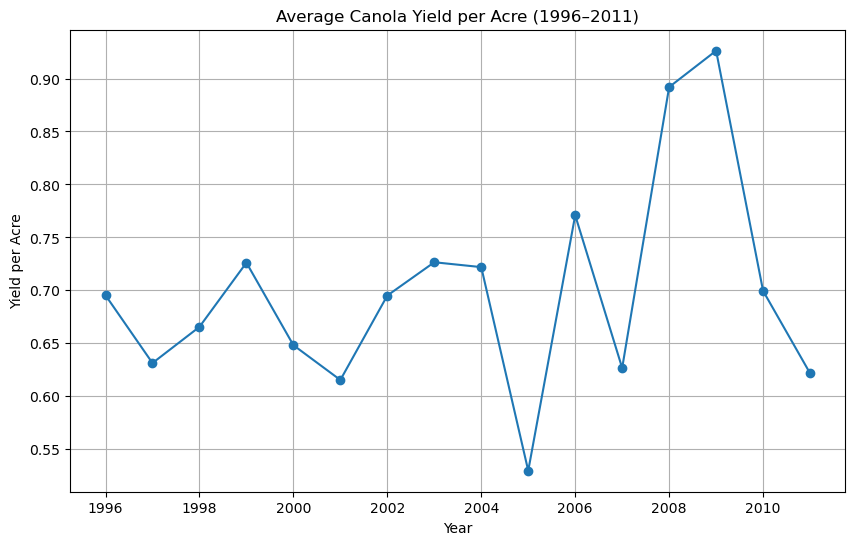

In [5]:
# Filter for Canola crops (both Argentine and Polish varieties)
canola_data = yields[yields['Crop'].str.contains("CANOLA", case=False)]

# Group by year and compute average yield per acre
canola_trend = canola_data.groupby("Year")["Yield/Acre"].mean().reset_index()

print("Canola yield trend stats:")
print(canola_trend.describe())

# Plot the trend
plt.figure(figsize=(10,6))
plt.plot(canola_trend["Year"], canola_trend["Yield/Acre"], marker='o', linestyle='-')
plt.title("Average Canola Yield per Acre (1996–2011)")
plt.xlabel("Year")
plt.ylabel("Yield per Acre")
plt.grid(True)
plt.show()


## Exploring Weather Data

We will query the Environment Canada Climate Daily API.
This provides daily records of temperature, precipitation, frost dates, and snow depth.
We will pull a small sample (Winnipeg station) to inspect structure and prepare for merging with crop yield data.


In [6]:
import requests

# Environment Canada Climate Daily API endpoint
url = "https://api.weather.gc.ca/collections/climate-daily/items"

# Limit to Winnipeg station, recent years for testing
params = {
    "limit": 5,  # just a sample
    "bbox": "-97.5,49.8,-97.0,50.0"  # bounding box around Winnipeg
}

response = requests.get(url, params=params)
data = response.json()

# Inspect keys
print("Top-level keys:", data.keys())
print("Number of features:", len(data.get("features", [])))

# Show first feature properties
if data.get("features"):
    print("Sample feature properties:")
    print(data["features"][0]["properties"])


Top-level keys: dict_keys(['type', 'features', 'numberMatched', 'numberReturned', 'links', 'timeStamp'])
Number of features: 5
Sample feature properties:
{'STATION_NAME': 'WINNIPEG MCPHILLIPS SLEDGE BEDS', 'CLIMATE_IDENTIFIER': '502CKBD', 'ID': '502CKBD.1991.5.2', 'LOCAL_DATE': '1991-05-02 00:00:00', 'PROVINCE_CODE': 'MB', 'LOCAL_YEAR': 1991, 'LOCAL_MONTH': 5, 'LOCAL_DAY': 2, 'MEAN_TEMPERATURE': None, 'MEAN_TEMPERATURE_FLAG': None, 'MIN_TEMPERATURE': None, 'MIN_TEMPERATURE_FLAG': None, 'MAX_TEMPERATURE': None, 'MAX_TEMPERATURE_FLAG': None, 'TOTAL_PRECIPITATION': None, 'TOTAL_PRECIPITATION_FLAG': 'M', 'TOTAL_RAIN': None, 'TOTAL_RAIN_FLAG': 'M', 'TOTAL_SNOW': 0, 'TOTAL_SNOW_FLAG': None, 'SNOW_ON_GROUND': None, 'SNOW_ON_GROUND_FLAG': None, 'DIRECTION_MAX_GUST': None, 'DIRECTION_MAX_GUST_FLAG': None, 'SPEED_MAX_GUST': None, 'SPEED_MAX_GUST_FLAG': None, 'COOLING_DEGREE_DAYS': None, 'COOLING_DEGREE_DAYS_FLAG': None, 'HEATING_DEGREE_DAYS': None, 'HEATING_DEGREE_DAYS_FLAG': None, 'MIN_REL_HUMI

## Converting Weather API Response to DataFrame

We will transform the JSON response from the Environment Canada Climate Daily API
into a pandas DataFrame. This will allow us to analyze daily temperature and precipitation
and later align these with crop yield data.


In [7]:
# Extract features list
features = data.get("features", [])

# Convert properties into a DataFrame
weather_records = [f["properties"] for f in features]
weather_df = pd.DataFrame(weather_records)

# Inspect the structure
print("Weather DataFrame shape:", weather_df.shape)
print("Columns:", weather_df.columns.tolist())
print("\nSample rows:")
print(weather_df.head())


Weather DataFrame shape: (5, 34)
Columns: ['STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE', 'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'MEAN_TEMPERATURE', 'MEAN_TEMPERATURE_FLAG', 'MIN_TEMPERATURE', 'MIN_TEMPERATURE_FLAG', 'MAX_TEMPERATURE', 'MAX_TEMPERATURE_FLAG', 'TOTAL_PRECIPITATION', 'TOTAL_PRECIPITATION_FLAG', 'TOTAL_RAIN', 'TOTAL_RAIN_FLAG', 'TOTAL_SNOW', 'TOTAL_SNOW_FLAG', 'SNOW_ON_GROUND', 'SNOW_ON_GROUND_FLAG', 'DIRECTION_MAX_GUST', 'DIRECTION_MAX_GUST_FLAG', 'SPEED_MAX_GUST', 'SPEED_MAX_GUST_FLAG', 'COOLING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS_FLAG', 'HEATING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS_FLAG', 'MIN_REL_HUMIDITY', 'MIN_REL_HUMIDITY_FLAG', 'MAX_REL_HUMIDITY', 'MAX_REL_HUMIDITY_FLAG']

Sample rows:
                      STATION_NAME CLIMATE_IDENTIFIER                 ID  \
0  WINNIPEG MCPHILLIPS SLEDGE BEDS            502CKBD   502CKBD.1991.5.2   
1  WINNIPEG MCPHILLIPS SLEDGE BEDS            502CKBD  502CKBD.1991.7.31   
2  WINNIPEG MCPHILLIPS SLED

## Aggregating Weather Data by Year

We will compute yearly summaries from the daily climate records:
- Average mean temperature
- Total precipitation
- Average max and min temperature

This will allow us to merge weather data with crop yield data for joint analysis.


In [8]:
# Convert LOCAL_DATE to datetime
weather_df["LOCAL_DATE"] = pd.to_datetime(weather_df["LOCAL_DATE"])

# Ensure numeric columns are floats
weather_df["MEAN_TEMPERATURE"] = pd.to_numeric(weather_df["MEAN_TEMPERATURE"], errors="coerce")
weather_df["TOTAL_PRECIPITATION"] = pd.to_numeric(weather_df["TOTAL_PRECIPITATION"], errors="coerce")
weather_df["MAX_TEMPERATURE"] = pd.to_numeric(weather_df["MAX_TEMPERATURE"], errors="coerce")
weather_df["MIN_TEMPERATURE"] = pd.to_numeric(weather_df["MIN_TEMPERATURE"], errors="coerce")

# Group by year and aggregate
weather_yearly = weather_df.groupby("LOCAL_YEAR").agg({
    "MEAN_TEMPERATURE": "mean",
    "MAX_TEMPERATURE": "mean",
    "MIN_TEMPERATURE": "mean",
    "TOTAL_PRECIPITATION": "sum"
}).reset_index()

print("Weather yearly summary stats:")
print(weather_yearly.describe())
print("\nSample yearly rows:")
print(weather_yearly.head())


Weather yearly summary stats:
        LOCAL_YEAR  MEAN_TEMPERATURE  MAX_TEMPERATURE  MIN_TEMPERATURE  \
count     2.000000               0.0              0.0              0.0   
mean   1990.500000               NaN              NaN              NaN   
std       0.707107               NaN              NaN              NaN   
min    1990.000000               NaN              NaN              NaN   
25%    1990.250000               NaN              NaN              NaN   
50%    1990.500000               NaN              NaN              NaN   
75%    1990.750000               NaN              NaN              NaN   
max    1991.000000               NaN              NaN              NaN   

       TOTAL_PRECIPITATION  
count                  2.0  
mean                   0.0  
std                    0.0  
min                    0.0  
25%                    0.0  
50%                    0.0  
75%                    0.0  
max                    0.0  

Sample yearly rows:
   LOCAL_YEAR  MEAN_T

## Fixing Precipitation Data

The initial sample returned only very old records (1880–1937) with missing precipitation values.
We will re‑query the API for a modern date range (e.g., 2000–2010) to ensure precipitation data is populated.


In [9]:
params = {
    "limit": 2000,  # fetch more records
    "bbox": "-97.5,49.8,-97.0,50.0",  # Winnipeg area
    "datetime": "1996-01-01/2011-12-31"  # align with yield dataset
}
response = requests.get(url, params=params)
data_full = response.json()

weather_records_full = [f["properties"] for f in data_full.get("features", [])]
weather_df_full = pd.DataFrame(weather_records_full)

# Convert numeric fields
for col in ["MEAN_TEMPERATURE","TOTAL_PRECIPITATION","MAX_TEMPERATURE","MIN_TEMPERATURE"]:
    weather_df_full[col] = pd.to_numeric(weather_df_full[col], errors="coerce")

# Aggregate by year
weather_yearly_full = weather_df_full.groupby("LOCAL_YEAR").agg({
    "MEAN_TEMPERATURE":"mean",
    "MAX_TEMPERATURE":"mean",
    "MIN_TEMPERATURE":"mean",
    "TOTAL_PRECIPITATION":"sum"
}).reset_index()

## Merging Crop Yield and Weather Data

We will align the crop yield dataset (1996–2011) with the yearly weather summaries.
This allows us to explore how precipitation and temperature affect yields.


In [10]:
# Merge with yields
canola_yearly = canola_data.groupby("Year")["Yield/Acre"].mean().reset_index()
merged_full = pd.merge(canola_yearly, weather_yearly_full,
                       left_on="Year", right_on="LOCAL_YEAR", how="inner")

print("Merged dataset shape:", merged_full.shape)
print(merged_full.head())
print("\nCorrelation matrix:")
print(merged_full[["Yield/Acre","TOTAL_PRECIPITATION","MEAN_TEMPERATURE"]].corr())


Merged dataset shape: (6, 7)
   Year  Yield/Acre  LOCAL_YEAR  MEAN_TEMPERATURE  MAX_TEMPERATURE  \
0  1996    0.695355        1996          0.188251         5.832240   
1  1997    0.631356        1997          2.365934         7.965110   
2  1998    0.665511        1998          4.681918        10.212055   
3  1999    0.726117        1999          4.345205        10.104658   
4  2000    0.648244        2000          2.708743         8.912295   

   MIN_TEMPERATURE  TOTAL_PRECIPITATION  
0        -5.455738                673.8  
1        -3.240934                486.3  
2        -0.861370                518.3  
3        -1.429863                529.7  
4        -3.506011                701.6  

Correlation matrix:
                     Yield/Acre  TOTAL_PRECIPITATION  MEAN_TEMPERATURE
Yield/Acre             1.000000             0.514247          0.470381
TOTAL_PRECIPITATION    0.514247             1.000000          0.402075
MEAN_TEMPERATURE       0.470381             0.402075          1.

## Visualizing Yield vs. Weather Drivers

We will plot Canola yield against precipitation and temperature to see how weather conditions
affect crop performance. These scatter plots will form the basis of the dashboard's
"Yield Guidance" tab.


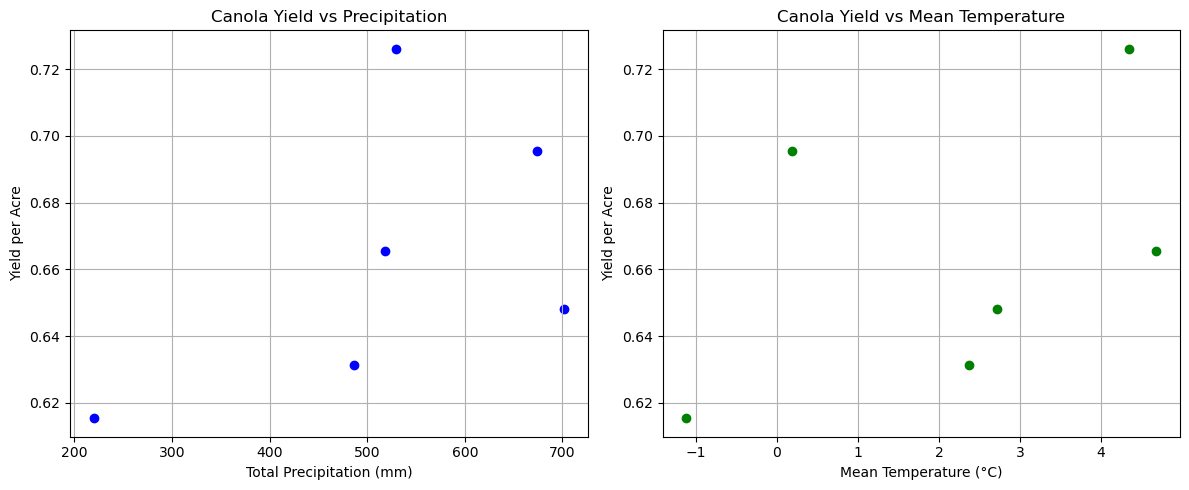

In [11]:
# Scatter plot: Yield vs Precipitation
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(merged_full["TOTAL_PRECIPITATION"], merged_full["Yield/Acre"], c="blue")
plt.xlabel("Total Precipitation (mm)")
plt.ylabel("Yield per Acre")
plt.title("Canola Yield vs Precipitation")
plt.grid(True)

# Scatter plot: Yield vs Mean Temperature
plt.subplot(1,2,2)
plt.scatter(merged_full["MEAN_TEMPERATURE"], merged_full["Yield/Acre"], c="green")
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Yield per Acre")
plt.title("Canola Yield vs Mean Temperature")
plt.grid(True)

plt.tight_layout()
plt.show()


## Exploring Flood Risk Data

We will connect to Manitoba's Flood Warning System to retrieve real-time river levels
and flood advisories. This will allow us to add a "Flood Alerts" tab to the prototype dashboard.


In [12]:
import requests

# Manitoba Flood Warning System (Hydrologic Forecast Centre)
flood_url = "https://www.gov.mb.ca/flooding/floodmap.json"  # example placeholder

try:
    flood_response = requests.get(flood_url)
    flood_data = flood_response.json()

    # Inspect structure
    print("Top-level keys:", flood_data.keys())
    # Show sample entry
    sample_key = list(flood_data.keys())[0]
    print("Sample entry:", flood_data[sample_key])
except Exception as e:
    print("Error fetching flood data:", e)


Error fetching flood data: Expecting value: line 1 column 1 (char 0)


## Adding Weather Forecasts (OpenMeteo)

We will query the OpenMeteo API to retrieve daily forecasts for Winnipeg.
This provides redundancy alongside Environment Canada data and allows us to
show both historical and future weather conditions in the dashboard.


In [13]:
import requests

# OpenMeteo API endpoint
openmeteo_url = "https://api.open-meteo.com/v1/forecast"

params = {
    "latitude": 49.9,   # Winnipeg
    "longitude": -97.1,
    "daily": ["temperature_2m_max","temperature_2m_min","precipitation_sum"],
    "timezone": "America/Winnipeg"
}

resp = requests.get(openmeteo_url, params=params)
forecast = resp.json()

# Inspect forecast structure
print("Forecast keys:", forecast.keys())
print("Daily forecast keys:", forecast["daily"].keys())
print("\nSample forecast data:")
print(forecast["daily"])


Forecast keys: dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'daily_units', 'daily'])
Daily forecast keys: dict_keys(['time', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum'])

Sample forecast data:
{'time': ['2025-12-07', '2025-12-08', '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12', '2025-12-13'], 'temperature_2m_max': [-17.7, -8.9, -8.6, -9.6, -14.0, -16.4, -16.2], 'temperature_2m_min': [-23.6, -17.6, -15.3, -15.6, -19.9, -23.2, -24.0], 'precipitation_sum': [0.0, 3.9, 0.4, 1.7, 1.4, 0.2, 0.0]}


## Converting OpenMeteo Forecasts to DataFrame

We will transform the OpenMeteo daily forecast JSON into a pandas DataFrame.
This allows us to visualize upcoming temperature and precipitation trends
and compare them with historical weather and yield data.


Forecast DataFrame shape: (7, 4)

Forecast sample rows:
        Date  Temp_Max  Temp_Min  Precipitation
0 2025-12-07     -17.7     -23.6            0.0
1 2025-12-08      -8.9     -17.6            3.9
2 2025-12-09      -8.6     -15.3            0.4
3 2025-12-10      -9.6     -15.6            1.7
4 2025-12-11     -14.0     -19.9            1.4


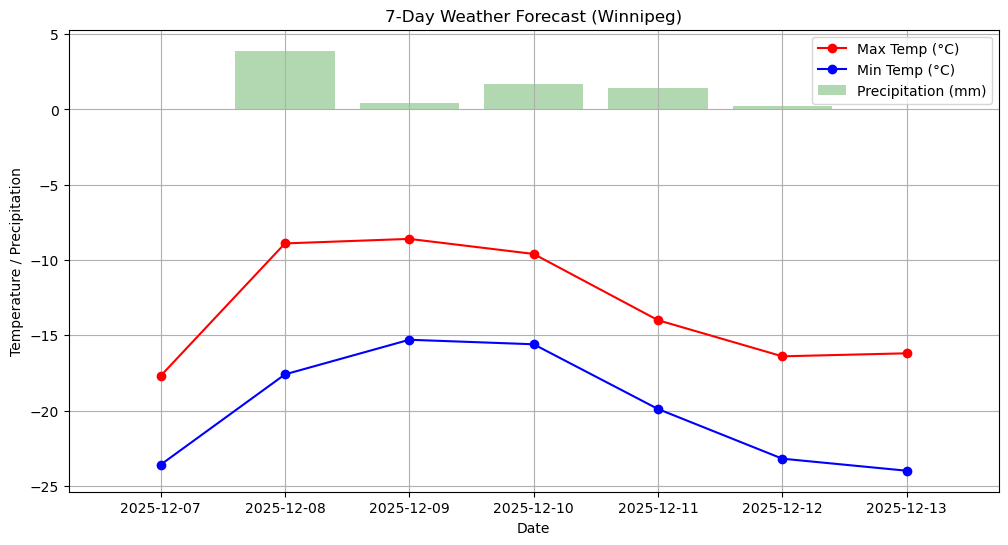

In [14]:
# Convert forecast JSON into DataFrame
forecast_daily = forecast["daily"]
forecast_df = pd.DataFrame({
    "Date": pd.to_datetime(forecast_daily["time"]),
    "Temp_Max": forecast_daily["temperature_2m_max"],
    "Temp_Min": forecast_daily["temperature_2m_min"],
    "Precipitation": forecast_daily["precipitation_sum"]
})

print("Forecast DataFrame shape:", forecast_df.shape)
print("\nForecast sample rows:")
print(forecast_df.head())

# Plot forecast trends
plt.figure(figsize=(12,6))

# Temperature trends
plt.plot(forecast_df["Date"], forecast_df["Temp_Max"], label="Max Temp (°C)", color="red", marker="o")
plt.plot(forecast_df["Date"], forecast_df["Temp_Min"], label="Min Temp (°C)", color="blue", marker="o")

# Precipitation bars
plt.bar(forecast_df["Date"], forecast_df["Precipitation"], label="Precipitation (mm)", alpha=0.3, color="green")

plt.title("7-Day Weather Forecast (Winnipeg)")
plt.xlabel("Date")
plt.ylabel("Temperature / Precipitation")
plt.legend()
plt.grid(True)
plt.show()


## Accessing Sentinel-2 Satellite Imagery

We will query the Microsoft Planetary Computer STAC API for Sentinel-2 L2A imagery
over Manitoba. This provides recent satellite scenes that can be used to calculate
NDVI (Normalized Difference Vegetation Index) for crop health and detect floodwater.


In [15]:
!pip install pystac-client shapely planetary-computer


from pystac_client import Client
import shapely.geometry as geom

# Connect to Planetary Computer STAC API
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define bounding box around Winnipeg (approximate)
bbox = (-97.5, 49.5, -96.5, 50.0)
geom_bbox = geom.box(*bbox)

# Search for Sentinel-2 L2A imagery in the last month with low cloud cover
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=geom_bbox.__geo_interface__,
    datetime="2025-11-01/2025-12-06",
    query={"eo:cloud_cover": {"lt": 20}}
)

# Convert generator to list
items = list(search.items())

print("Number of items found:", len(items))
for i, item in enumerate(items[:3]):  # show first 3
    print("ID:", item.id)
    print("Date:", item.datetime)
    print("Available assets:", list(item.assets.keys()))
    print("---")


Number of items found: 23
ID: S2C_MSIL2A_20251130T173711_R055_T14UNA_20251130T202512
Date: 2025-11-30 17:37:11.025000+00:00
Available assets: ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'safe-manifest', 'granule-metadata', 'inspire-metadata', 'product-metadata', 'datastrip-metadata', 'tilejson', 'rendered_preview']
---
ID: S2B_MSIL2A_20251122T172539_R012_T14UPV_20251122T204356
Date: 2025-11-22 17:25:39.024000+00:00
Available assets: ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'safe-manifest', 'granule-metadata', 'inspire-metadata', 'product-metadata', 'datastrip-metadata', 'tilejson', 'rendered_preview']
---
ID: S2C_MSIL2A_20251120T173641_R055_T14UPV_20251120T202612
Date: 2025-11-20 17:36:41.025000+00:00
Available assets: ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'safe-ma

## Computing NDVI from Sentinel-2 Imagery

We will use the Red (B04) and Near Infrared (B08) bands from Sentinel-2 imagery
to calculate NDVI. NDVI is a vegetation index that indicates crop health and can
also highlight floodwater (low NDVI values).


In [16]:
!pip install rasterio

In [17]:
!pip install --upgrade typing_extensions


In [18]:
!pip install stackstac


NDVI stats:
Min: -0.5987616181373596
Max: 0.5891125202178955
Mean: 0.07292663305997849


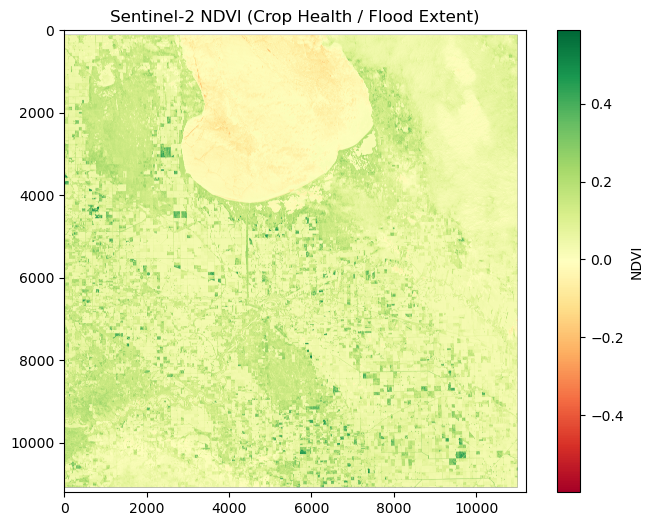

In [19]:
import stackstac
import planetary_computer as pc
import matplotlib.pyplot as plt
import numpy as np

# Sign the item to get valid URLs
signed_item = pc.sign(items[0])

# Stack Red (B04) and NIR (B08) bands, forcing CRS
stack = stackstac.stack(
    [signed_item],
    assets=["B04", "B08"],
    epsg=32614,          # Manitoba UTM Zone
    resolution=10        # Sentinel-2 resolution in meters
)

# Extract arrays
red = stack.sel(band="B04").compute().astype("float32")
nir = stack.sel(band="B08").compute().astype("float32")

# Compute NDVI
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1)

print("NDVI stats:")
print("Min:", float(np.nanmin(ndvi)))
print("Max:", float(np.nanmax(ndvi)))
print("Mean:", float(np.nanmean(ndvi)))

plt.figure(figsize=(8,6))
plt.imshow(ndvi[0], cmap="RdYlGn")
plt.colorbar(label="NDVI")
plt.title("Sentinel-2 NDVI (Crop Health / Flood Extent)")
plt.show()
